In [1]:
import pandas as pd
import numpy as np

#Data Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set(font_scale=1)
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#Modeling
import fasttext
from sklearn.model_selection import cross_val_predict, cross_val_score, RandomizedSearchCV,StratifiedKFold, KFold, train_test_split
from sklearn.feature_extraction import DictVectorizer

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn_crfsuite import CRF, scorers, metrics
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.metrics import classification_report, make_scorer
import scipy.stats
import eli5

In [33]:
data = pd.read_csv("../Dataset/annotated_ner_data_new.csv")
data=data[:50013]
data

,token,ner,tweet_id,index
0,Hidup,O,1382601382042103808,0
1,sesedih,O,1382601382042103808,1
2,dan,O,1382601382042103808,2
3,secaper,O,1382601382042103808,3
4,apa,O,1382601382042103808,4
...,...,...,...,...
50008,kualitas,O,1387559264395223042,16
50009,SDM,O,1387559264395223042,17
50010,serta,O,1387559264395223042,18
50011,penurunan,O,1387559264395223042,19


In [34]:
#data.groupby('ner').size().reset_index(name='count tag')

In [35]:
#data.groupby('tweet_id').size().reset_index(name='token')

In [41]:
X = np.array(data.drop('ner', axis=1))
y = np.array(data.ner.values)

In [49]:
from collections import Counter
kf= KFold(n_splits=5, random_state=1, shuffle=True)
for train_index, test_index in kf.split(X):
    print(train_index, test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print(len(X_train), len(X_test))
    print(Counter(y_train))

[    0     1     3 ... 50010 50011 50012] [    2    10    11 ... 49997 49999 50009]
40010 10003
Counter({'O': 34662, 'B-PER': 1363, 'B-PROD': 844, 'I-PER': 720, 'B-LOC': 565, 'B-ORG': 491, 'I-ORG': 255, 'I-PROD': 255, 'B-EV': 253, 'I-EV': 250, 'I-LOC': 243, 'I-WA': 64, 'B-WA': 45})
[    0     1     2 ... 50009 50011 50012] [    3     8    19 ... 49992 50007 50010]
40010 10003
Counter({'O': 34594, 'B-PER': 1382, 'B-PROD': 860, 'I-PER': 728, 'B-LOC': 594, 'B-ORG': 506, 'I-ORG': 273, 'B-EV': 248, 'I-EV': 244, 'I-LOC': 240, 'I-PROD': 232, 'I-WA': 60, 'B-WA': 49})
[    1     2     3 ... 50010 50011 50012] [    0    13    26 ... 49986 49990 50008]
40010 10003
Counter({'O': 34612, 'B-PER': 1388, 'B-PROD': 827, 'I-PER': 754, 'B-LOC': 576, 'B-ORG': 506, 'I-EV': 264, 'B-EV': 251, 'I-ORG': 251, 'I-PROD': 241, 'I-LOC': 229, 'I-WA': 66, 'B-WA': 45})
[    0     2     3 ... 50010 50011 50012] [    1     4     5 ... 50003 50005 50006]
40011 10002
Counter({'O': 34589, 'B-PER': 1394, 'B-PROD': 854, 'I-P

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=0)
X_train.shape, y_train.shape

((33508, 3), (33508,))

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170070 entries, 0 to 170069
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   token     170070 non-null  object
 1   ner       170070 non-null  object
 2   tweet_id  170070 non-null  int64 
 3   index     170070 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 5.2+ MB


In [4]:
data.loc[data['ner'] == 'B-PER', 'token']

31             Nadiem
37           Megawati
89        @daya_hadid
129             Anies
134              Ahok
             ...     
169995         Ridwan
170013       Megawati
170041          Sahar
170047         renjun
170059         renjun
Name: token, Length: 5564, dtype: object

d:\Drive\KULEEAH\Semester 8\TA Farihin\env\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


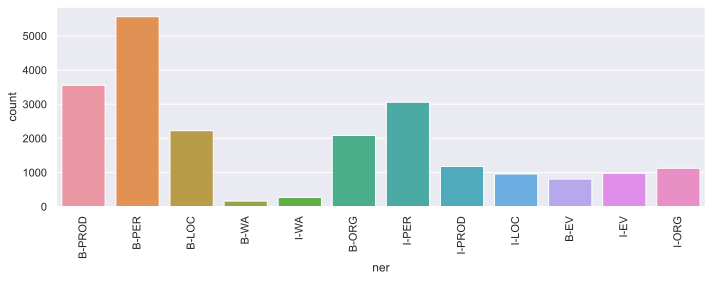

In [5]:
#Words distribution across Tags without O tag
plt.figure(figsize=(10, 4))
ax = sns.countplot('ner', data=data.loc[data['ner'] != 'O'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

In [6]:
class getsentence(object):
    
    def __init__(self, data):
        self.n_sent = 1.0
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["token"].values.tolist(),
                                                     s["ner"].values.tolist())]
        self.grouped = self.data.groupby("tweet_id").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [7]:
getter = getsentence(data)
sentences = getter.sentences
#This is how a sentence will look like. 
print(sentences[:1])

[[('@ridwankamil', 'O'), ('@KickAndyShow', 'O'), ('@Metro_TV', 'O'), ('Upaya', 'O'), ('untuk', 'O'), ('mnaikan', 'O'), ('nilai', 'O'), ('jual', 'O'), ('yg', 'O'), ('bgus,dngn', 'O'), ('cara', 'O'), ('d', 'O'), ('desain', 'O'), ('pak', 'O'), ('gubernur', 'B-PER'), ('akan', 'O'), ('menjadikn', 'O'), ('produk', 'O'), ('umkm', 'O'), ('d', 'O'), ('mintai', 'O'), ('krena', 'O'), ('yg', 'O'), ('desain', 'O'), ('org', 'O'), ('nomer', 'O'), ('satu', 'O'), ('di', 'O'), ('jabar', 'B-LOC')]]


In [8]:
words = list(set(data["token"].values))
n_words = len(words)
print(n_words)

35418


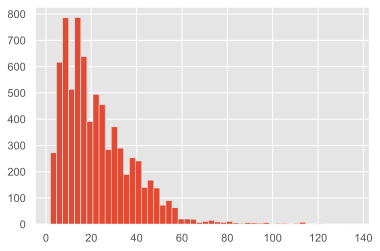

In [9]:
#Lets visualize how the sentences are distributed by their length
plt.style.use("ggplot")
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [12]:
# Feature set
def word2features(sent, i):
    word = sent[i][0]
    # we=get_features(word) 
    # postag = sent[i][1]

    
    features = {
        'bias': 1.0,
        'word.lower()': word.lower() if type(word) == str else word,
        'word[-3:]': word[-3:] if type(word) == str else word,
        'word[-2:]': word[-2:] if type(word) == str else word,
        'word[-1:]': word[-2:] if type(word) == str else word,
        'word[:3]': word[:3] if type(word) == str else word,
        'word[:2]': word[:2] if type(word) == str else word,
        'word[:1]': word[:2] if type(word) == str else word,
        'word.isupper()': word.isupper() if type(word) == str else word,
        'word.istitle()': word.istitle() if type(word) == str else word,
        'word.isdigit()': word.isdigit() if type(word) == str else word,
        # 'postag': postag,
        # 'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        # postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower() if type(word1) == str else word1,
            '-1:word.istitle()': word1.istitle() if type(word1) == str else word1,
            '-1:word.isupper()': word1.isupper() if type(word1) == str else word1,
            # '-1:postag': postag1,
            # '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        # postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower() if type(word1) == str else word1,
            '+1:word.istitle()': word1.istitle() if type(word1) == str else word1,
            '+1:word.isupper()': word1.isupper() if type(word1) == str else word1,
            # '+1:postag': postag1,
            # '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    #src: https://stackoverflow.com/questions/58736548/how-to-use-word-embedding-as-features-for-crf-sklearn-crfsuite-model-training
    # we=model.get_word_vector(features['word.lower()'])
    # for iv,value in enumerate(we):
    #     features['v{}'.format(iv)]=value

    return features

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, label in sent]

In [13]:
#Creating the train and test set
X = [sent2features(s) for s in sentences]
y = [sent2labels(s) for s in sentences]

In [14]:
X

ord.istitle()': True,
   '-1:word.isupper()': False,
   '+1:word.lower()': 'fx',
   '+1:word.istitle()': False,
   '+1:word.isupper()': True},
  {'bias': 1.0,
   'word.lower()': 'fx',
   'word[-3:]': 'FX',
   'word[-2:]': 'FX',
   'word[-1:]': 'FX',
   'word[:3]': 'FX',
   'word[:2]': 'FX',
   'word[:1]': 'FX',
   'word.isupper()': True,
   'word.istitle()': False,
   'word.isdigit()': False,
   '-1:word.lower()': 'prabowo',
   '-1:word.istitle()': True,
   '-1:word.isupper()': False,
   '+1:word.lower()': 'rudy',
   '+1:word.istitle()': True,
   '+1:word.isupper()': False},
  {'bias': 1.0,
   'word.lower()': 'rudy',
   'word[-3:]': 'udy',
   'word[-2:]': 'dy',
   'word[-1:]': 'dy',
   'word[:3]': 'Rud',
   'word[:2]': 'Ru',
   'word[:1]': 'Ru',
   'word.isupper()': False,
   'word.istitle()': True,
   'word.isdigit()': False,
   '-1:word.lower()': 'fx',
   '-1:word.istitle()': False,
   '-1:word.isupper()': True,
   '+1:word.lower()': 'jagokan',
   '+1:word.istitle()': True,
   '+1:wo

In [15]:
sentences[11]

[('Menteri', 'O'),
 ('Erick', 'B-PER'),
 ('Thohir', 'I-PER'),
 ('didampingi', 'O'),
 ('Ridwan', 'B-PER'),
 ('Kamil', 'I-PER'),
 ('tinjau', 'O'),
 ('Pertashop', 'B-PROD'),
 ('di', 'O'),
 ('Lembang', 'B-LOC'),
 ('-', 'O'),
 ('ANTARA', 'B-ORG'),
 ('News', 'I-ORG'),
 ('Jawa', 'I-ORG'),
 ('Barat', 'I-ORG'),
 ('https://t.co/w7m7OqPbnG', 'O')]

In [16]:
def find_consecutive_ne(sentence):
    full_entities = []
    prev_tag = "O"
    for token, full_tag in sentence:
        start_tag=full_tag[:1]
        tag= full_tag[2:] if full_tag!='O' else 'O'
        if tag == "O":
            prev_tag = tag
            continue

        if start_tag == 'B': # Begin NE
            full_entities.append([token,tag])
        elif start_tag == 'I' and prev_tag == tag: # Inside NE
            full_entities[-1][0]  = full_entities[-1][0]+" "+ token
        prev_tag = tag
    return full_entities

def count_ne(sentence):
    counter={
        'PER':0,
        'LOC':0,
        'ORG':0,
        'PROD':0,
        'WA':0,
        'EV':0
    }
    for _, tag in sentence:
        counter[tag]+=1
    return counter

In [18]:
full_tag = [find_consecutive_ne(s) for s in sentences]

In [19]:
find_consecutive_ne(sentences[11])

[['Erick Thohir', 'PER'],
 ['Ridwan Kamil', 'PER'],
 ['Pertashop', 'PROD'],
 ['Lembang', 'LOC'],
 ['ANTARA News Jawa Barat', 'ORG']]

In [20]:
count_ne(find_consecutive_ne(sentences[11]))

{'PER': 2, 'LOC': 1, 'ORG': 1, 'PROD': 1, 'WA': 0, 'EV': 0}

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        train_size=0.8,
        test_size=0.2,
        # random but same for all run, also accurancy depends on the
        # selection of data e.g. if we put 10 then accuracy will be 1.0
        # in this example
        random_state=23,
        # keep same proportion of 'target' in test and target data
    )

In [24]:
X[0]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [14]:
# mlb=MultiLabelBinarizer()
# skf=StratifiedKFold(n_splits=5, random_state=1)
# for train_index, test_index in rskf.split(X, y):
#         X_train, X_test = X[train_index], X[test_index]
#         y_train, y_test = y[train_index], y[test_index]
#         print(len(X_train), (X_test))



d:\Drive\KULEEAH\Semester 8\TA Farihin\env\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
d:\Drive\KULEEAH\Semester 8\TA Farihin\env\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


ValueError: You appear to be using a legacy multi-label data representation. Sequence of sequences are no longer supported; use a binary array or sparse matrix instead - the MultiLabelBinarizer transformer can convert to this format.

In [33]:
kf= KFold(n_splits=2, random_state=1)
for train_index, test_index in kf.split([np.array(i) for i in X], np.array(y)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        print(len(X_train), (X_test))

d:\Drive\KULEEAH\Semester 8\TA Farihin\env\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
ipykernel_launcher:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


TypeError: only integer scalar arrays can be converted to a scalar index

In [32]:
[np.array(i) for i in X]

[:1]': 'me', 'word.isupper()': False, 'word.istitle()': False, 'word.isdigit()': False, '-1:word.lower()': 'akan', '-1:word.istitle()': False, '-1:word.isupper()': False, '+1:word.lower()': 'produk', '+1:word.istitle()': False, '+1:word.isupper()': False},
       {'bias': 1.0, 'word.lower()': 'produk', 'word[-3:]': 'duk', 'word[-2:]': 'uk', 'word[-1:]': 'uk', 'word[:3]': 'pro', 'word[:2]': 'pr', 'word[:1]': 'pr', 'word.isupper()': False, 'word.istitle()': False, 'word.isdigit()': False, '-1:word.lower()': 'menjadikn', '-1:word.istitle()': False, '-1:word.isupper()': False, '+1:word.lower()': 'umkm', '+1:word.istitle()': False, '+1:word.isupper()': False},
       {'bias': 1.0, 'word.lower()': 'umkm', 'word[-3:]': 'mkm', 'word[-2:]': 'km', 'word[-1:]': 'km', 'word[:3]': 'umk', 'word[:2]': 'um', 'word[:1]': 'um', 'word.isupper()': False, 'word.istitle()': False, 'word.isdigit()': False, '-1:word.lower()': 'produk', '-1:word.istitle()': False, '-1:word.isupper()': False, '+1:word.lower()':